In [59]:
import json
import tensorflow as tf
from tensorflow.keras import Input
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Configuring TensorFlow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


#### Datasets

In [40]:
# drugs
drugs = pd.read_csv('../data/drugs.csv', index_col=1)
drugs.drop(['Unnamed: 0'], axis=1, inplace=True)

# cell lines
cell_lines = pd.read_csv('../data/gene_expression.csv', index_col=0)

# combinations
combinations = pd.read_csv('../data/combinations.csv', index_col=0)

In [41]:
# reduce cell lines to the 2128 most important genes

with open('../data/2128_genes.pkl', 'rb') as f:
    top_genes = pickle.load(f)

filtered_cell_lines = cell_lines[cell_lines.columns.intersection(top_genes)]

In [42]:
combinations

,Drug_ID,Cell Line_ID,Y
0,Camptothecin,HCC1954,-0.251083
1,Camptothecin,HCC1143,1.343315
2,Camptothecin,HCC1187,1.736985
3,Camptothecin,HCC1395,-2.309078
4,Camptothecin,HCC1599,-3.106684
...,...,...,...
92698,JQ1,EFM-192A,3.576583
92699,JQ1,HCC1428,1.402466
92700,JQ1,HDQ-P1,2.762460
92701,JQ1,JIMT-1,3.442930


### Merge data

In [43]:
drugs

,Drug
Drug_ID,
Camptothecin,CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=...
Vinblastine,CC[C@@]1(CC2C[C@@](C3=C(CCN(C2)C1)C4=CC=CC=C4N...
Cisplatin,N.N.[Cl-].[Cl-].[Pt+2]
Cytarabine,C1=CN(C(=O)N=C1N)[C@H]2[C@H]([C@@H]([C@H](O2)C...
Docetaxel,CC1=C2[C@H](C(=O)[C@@]3([C@H](C[C@@H]4[C@]([C@...
...,...
LJI308,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...
GSK591,C1CC(C1)NC2=NC=CC(=C2)C(=O)NC[C@@H](CN3CCC4=CC...
VE821,CS(=O)(=O)C1=CC=C(C=C1)C2=CN=C(C(=N2)C(=O)NC3=...


In [44]:
# transform smiles to fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    return fp

def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return fp

drugs['Drug'] = drugs['Drug'].apply(smiles_to_fingerprint)
drugs

,Drug
Drug_ID,
Camptothecin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Vinblastine,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
Cisplatin,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Cytarabine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Docetaxel,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...
LJI308,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
GSK591,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
VE821,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [45]:
drugs = pd.concat([drugs.drop(['Drug'], axis=1), drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
drugs

,fp0,fp1,fp2,fp3,fp4,fp5,fp6,fp7,fp8,fp9,...,fp1014,fp1015,fp1016,fp1017,fp1018,fp1019,fp1020,fp1021,fp1022,fp1023
Drug_ID,,,,,,,,,,,,,,,,,,,,,
Camptothecin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Vinblastine,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
Cisplatin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cytarabine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
Docetaxel,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LJI308,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
GSK591,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
VE821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# merge cell lines and drugs considering the combinations
final_df = pd.merge(combinations, drugs, on='Drug_ID')
final_df = pd.merge(final_df, filtered_cell_lines, left_on='Cell Line_ID', right_index=True, how = 'inner')
final_df.index = final_df['Drug_ID'] + '_' + final_df['Cell Line_ID']
final_df

,Drug_ID,Cell Line_ID,Y,fp0,fp1,fp2,fp3,fp4,fp5,fp6,...,ATP6V1E2,ZNF345,ATXN7L3B,PRKDC,PBOV1,OR13A1,ZNF253,MRPL46,OR1D5,MYH4
Camptothecin_HCC1954,Camptothecin,HCC1954,-0.251083,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Vinblastine_HCC1954,Vinblastine,HCC1954,-3.058914,1,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cisplatin_HCC1954,Cisplatin,HCC1954,5.005908,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Cytarabine_HCC1954,Cytarabine,HCC1954,3.947056,0,0,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
Docetaxel_HCC1954,Docetaxel,HCC1954,-4.177968,0,1,0,0,0,0,0,...,5.120570,4.638312,5.598942,5.947629,3.032667,3.229141,4.110379,8.629097,3.228033,2.632448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MK-2206_HCC202,MK-2206,HCC202,1.585069,0,0,0,0,1,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Palbociclib_HCC202,Palbociclib,HCC202,4.867165,0,0,0,0,1,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
Pictilisib_HCC202,Pictilisib,HCC202,0.583059,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746
5-Fluorouracil_HCC202,5-Fluorouracil,HCC202,5.998151,0,0,0,0,0,0,0,...,5.509141,4.717170,6.264891,5.572891,2.870909,3.351663,4.704318,8.333207,3.714531,2.647746


In [47]:
# selected_columns = final_df.filter(regex='^fp', axis=1)
# selected_columns

In [48]:
# selected_columns = final_df.iloc[:, final_df.columns.get_loc('fp1023') + 1:]
# selected_columns

### Dataset splitting ###

In [49]:
output = final_df['Y']
input = final_df.drop(['Drug_ID', 'Cell Line_ID', 'Y'], axis=1)

In [51]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(input)
# input = scaler.transform(input)

In [55]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(input, output, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

In [56]:
x_train_drugs = x_train.filter(regex='^fp', axis=1)
x_train_cell_lines = x_train.iloc[:, x_train.columns.get_loc('fp1023') + 1:]

x_val_drugs = x_val.filter(regex='^fp', axis=1)
x_val_cell_lines = x_val.iloc[:, x_val.columns.get_loc('fp1023') + 1:]

x_test_drugs = x_test.filter(regex='^fp', axis=1)
x_test_cell_lines = x_test.iloc[:, x_test.columns.get_loc('fp1023') + 1:]

In [57]:
from sklearn.preprocessing import StandardScaler
scaler_train = StandardScaler()
scaler_train.fit(x_train)
x_train = scaler_train.transform(x_train)

scaler_val = StandardScaler()
scaler_val.fit(x_val)
x_val = scaler_val.transform(x_val)

scaler_test = StandardScaler()
scaler_test.fit(x_test)
x_test = scaler_test.transform(x_test)

### build dense attention layer

In [18]:
import tensorflow as tf

class DenseAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, return_alphas=False, name=None):
        super(DenseAttentionLayer, self).__init__(name=name)
        self.return_alphas = return_alphas

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.feature_size = feature_size

        self.attention = tf.keras.layers.Dense(feature_size, activation=tf.nn.softmax, name='attention')
        super(DenseAttentionLayer, self).build(input_shape)

    def call(self, inputs):
        alphas = self.attention(inputs)
        output = tf.multiply(inputs, alphas, name='filtered_with_attention')

        return (output, alphas) if self.return_alphas else output

    def compute_output_shape(self, input_shape):
        if self.return_alphas:
            return [(input_shape[0], self.feature_size), (input_shape[0], self.feature_size)]
        else:
            return input_shape[:-1] + (self.feature_size,)

# Example usage:
input_sequence = tf.random.normal(shape=(10, 4))  # (batch_size, sequence_length, feature_size)
attention_layer = DenseAttentionLayer(return_alphas=True)
output_sequence, attention_weights = attention_layer(input_sequence)


In [63]:
class IC50PredictionModel:
    def __init__(self, cell_line_feature_size, drug_feature_size):
        self.cell_line_feature_size = cell_line_feature_size
        self.drug_feature_size = drug_feature_size
        self.model = self.build_model()

    def build_model(self):
        # Define input layers
        cell_line_input = Input(shape=(self.cell_line_feature_size,), name='cell_line_input')
        drug_input = Input(shape=(self.drug_feature_size,), name='drug_input')

        # # # Define subnetworks for cell line and drug
        # cell_line_subnet = Dense(self.cell_line_feature_size, activation='sigmoid')(cell_line_input)
        # drug_subnet = Dense(self.drug_feature_size, activation='sigmoid')(drug_input)

        # Add attention mechanism to cell line subnetwork
        attention_cell_line = DenseAttentionLayer(return_alphas=True, name='cell_line_attention_layer')(cell_line_input)
        attended_cell_line = DenseAttentionLayer(return_alphas=True, name='drug_attention_layer')(drug_input)

        # Extract outputs and attention weights from attention layers
        cell_line_output, self.cell_line_alphas = attention_cell_line
        drug_output, self.drug_alphas = attended_cell_line

        # Concatenate the outputs of the attended subnetworks
        concatenated_features = Concatenate(name = 'input_layer_concat')([cell_line_output, drug_output])

        # Final network for IC50 prediction
        final_network = Dense(concatenated_features.shape[1], activation='sigmoid', name='ic50_prediction_dense_input')(concatenated_features)
        final_network = BatchNormalization()(final_network)
        final_network = Dropout(0.5)(final_network)

        final_network = Dense(512, activation='sigmoid', name='ic50_prediction_dense_512')(final_network)
        final_network = BatchNormalization()(final_network)
        final_network = Dropout(0.5)(final_network)

        final_network = Dense(256, activation='sigmoid', name='ic50_prediction_dense_256')(final_network)
        final_network = BatchNormalization()(final_network)
        final_network = Dropout(0.5)(final_network)

        final_network = Dense(128, activation='sigmoid', name='ic50_prediction_dense_128')(final_network)
        final_network = BatchNormalization()(final_network)
        final_network = Dropout(0.5)(final_network)

        # final_network = Dense(64, activation='sigmoid', name='ic50_prediction_dense_64')(final_network)
        # final_network = BatchNormalization()(final_network)
        # final_network = Dropout(0.5)(final_network)

        # final_network = Dense(32, activation='sigmoid', name='ic50_prediction_dense_32')(final_network)
        # final_network = BatchNormalization()(final_network)
        # final_network = Dropout(0.5)(final_network)

        # final_network = Dense(16, activation='sigmoid', name='ic50_prediction_dense_16')(final_network)
        # final_network = BatchNormalization()(final_network)
        # final_network = Dropout(0.5)(final_network)

        final_network = Dense(1, activation='linear', name='ic50_prediction_dense_output')(final_network)


        # Create the model
        model = tf.keras.Model(inputs=[cell_line_input, drug_input], outputs=final_network)

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

        return model

    def summary(self):
        self.model.summary()

    def train(self, cell_line_train_data, drug_train_data, train_labels, epochs, batch_size):
        self.history = self.model.fit(
            {'cell_line_input': cell_line_train_data, 'drug_input': drug_train_data},
            {'ic50_prediction_dense_output': train_labels},
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2
        )

    def evaluate(self, cell_line_test_data, drug_test_data, test_labels):
        return self.model.evaluate(
            {'cell_line_input': cell_line_test_data, 'drug_input': drug_test_data},
            {'ic50_prediction_dense_output': test_labels}
        )

    def predict(self, new_cell_line_data, new_drug_data):
        return self.model.predict({'cell_line_input': new_cell_line_data, 'drug_input': new_drug_data})


# Example usage
cell_line_feature_size = x_test_cell_lines.shape[1]
drug_feature_size = x_test_drugs.shape[1]

model = IC50PredictionModel(cell_line_feature_size, drug_feature_size)
print(model.summary())
# Assuming you have train_data, train_labels, test_data, and test_labels
model.train(x_train_cell_lines, x_train_drugs, y_train, epochs=10, batch_size=32)

val_loss, val_mae = model.evaluate(x_val_cell_lines, x_val_drugs, y_val)
print(f'Test Loss: {val_loss}, Test MAE: {val_mae}')

# Assuming you have new_data for prediction
predictions = model.predict(x_test_cell_lines, x_test_drugs)
print(predictions)


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cell_line_input (InputLayer)   [(None, 2089)]       0           []                               
                                                                                                  
 drug_input (InputLayer)        [(None, 1024)]       0           []                               
                                                                                                  
 cell_line_attention_layer (Den  ((None, 2089),      4366010     ['cell_line_input[0][0]']        
 seAttentionLayer)               (None, 2089))                                                    
                                                                                                  
 drug_attention_layer (DenseAtt  ((None, 1024),      1049600     ['drug_input[0][0]']      

KeyboardInterrupt: 

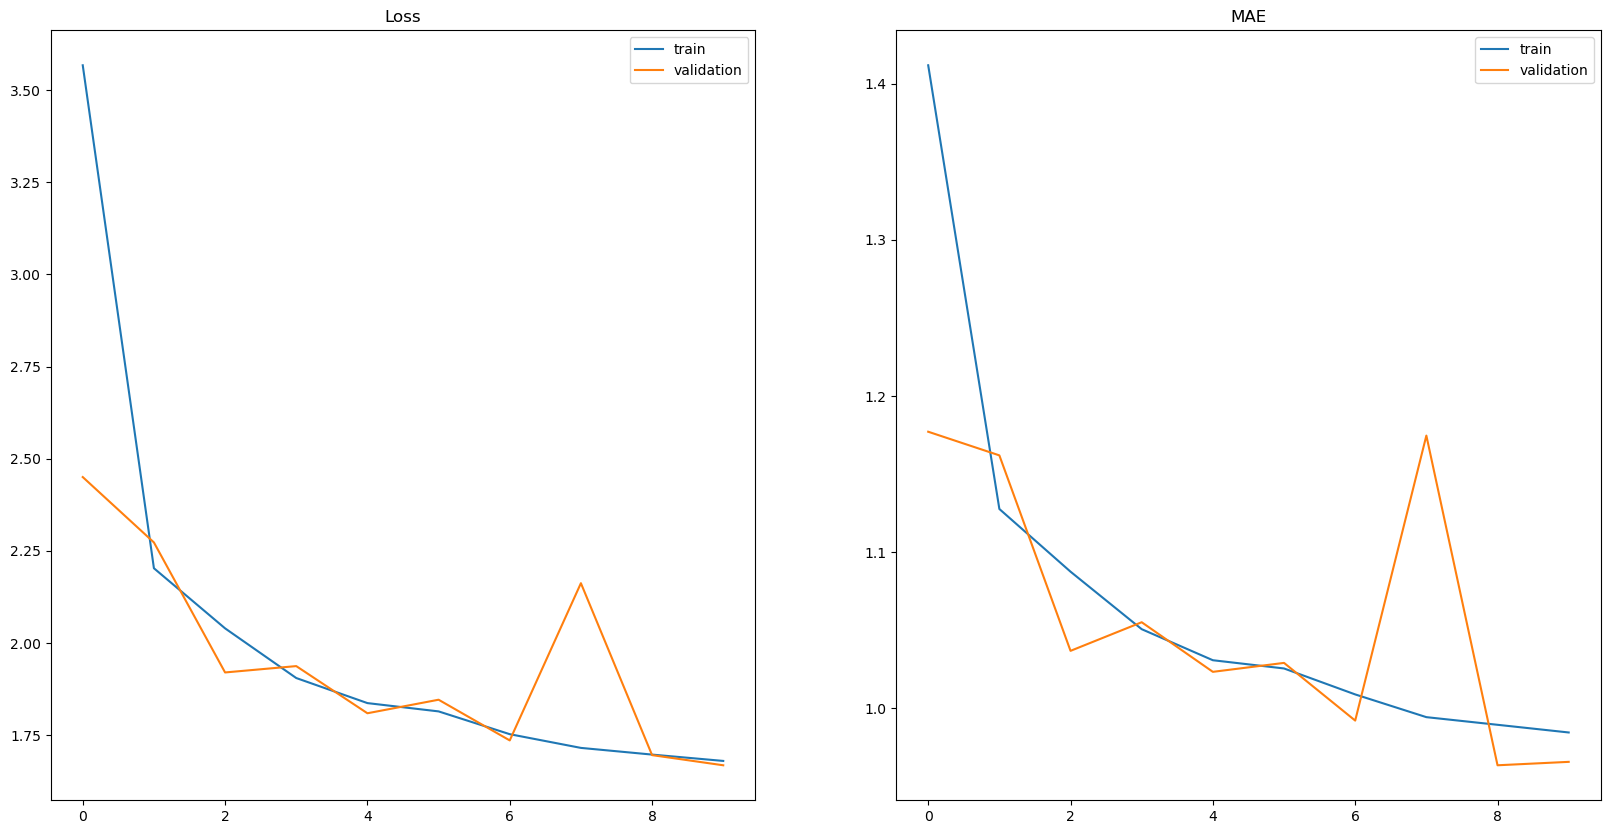

In [55]:
#plot loss and mae from training and validation data side by side
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.history.history['mae'], label='train')
plt.plot(model.history.history['val_mae'], label='validation')
plt.title('MAE')
plt.legend()
plt.show()





In [20]:

# Define input layers
cell_line_input = Input(shape=(10,), name='cell_line_input')
drug_input = Input(shape=(10,), name='drug_input')

# Define subnetworks for cell line and drug
cell_line_subnet = Dense(128, activation='relu', name = 'cell_line_encoder')(cell_line_input)
drug_subnet = Dense(128, activation='relu', name = 'drug_encoder')(drug_input)

# Add dense attention layers after the initial dense layers
cell_line_attention = DenseAttentionLayer(return_alphas=True, name='cell_line_attention_layer')(cell_line_subnet)
drug_attention = DenseAttentionLayer(return_alphas=True, name='drug_attention_layer')(drug_subnet)

# Extract outputs and attention weights from attention layers
cell_line_output, cell_line_alphas = cell_line_attention
drug_output, drug_alphas = drug_attention

# Concatenate the outputs of subnetworks
final_layer = Concatenate(name = 'input_layer_concat')([cell_line_output, drug_output])


# Final network for IC50 prediction
final_output = Dense(1, activation='linear', name='ic50_prediction')(final_layer)

# Build the complete model
model = tf.keras.Model(inputs=[cell_line_input, drug_input], outputs=final_output)




In [21]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cell_line_input (InputLaye  [(None, 10)]                 0         []                            
 r)                                                                                               
                                                                                                  
 drug_input (InputLayer)     [(None, 10)]                 0         []                            
                                                                                                  
 cell_line_encoder (Dense)   (None, 128)                  1408      ['cell_line_input[0][0]']     
                                                                                                  
 drug_encoder (Dense)        (None, 128)                  1408      ['drug_input[0][0]']    